Load in necessary libraries

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import kstest, poisson, pearsonr
from math import sqrt

Define R squared and RMSE values

In [12]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [203]:
# read in data 
flowdata = pd.read_csv("london_flows.csv")

In [204]:
flowdata

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [205]:
flow_OD=flowdata

Produce a distribution of flows to analyse whether goes by inverse power law or negative exponential

Text(0, 0.5, 'Total Flows')

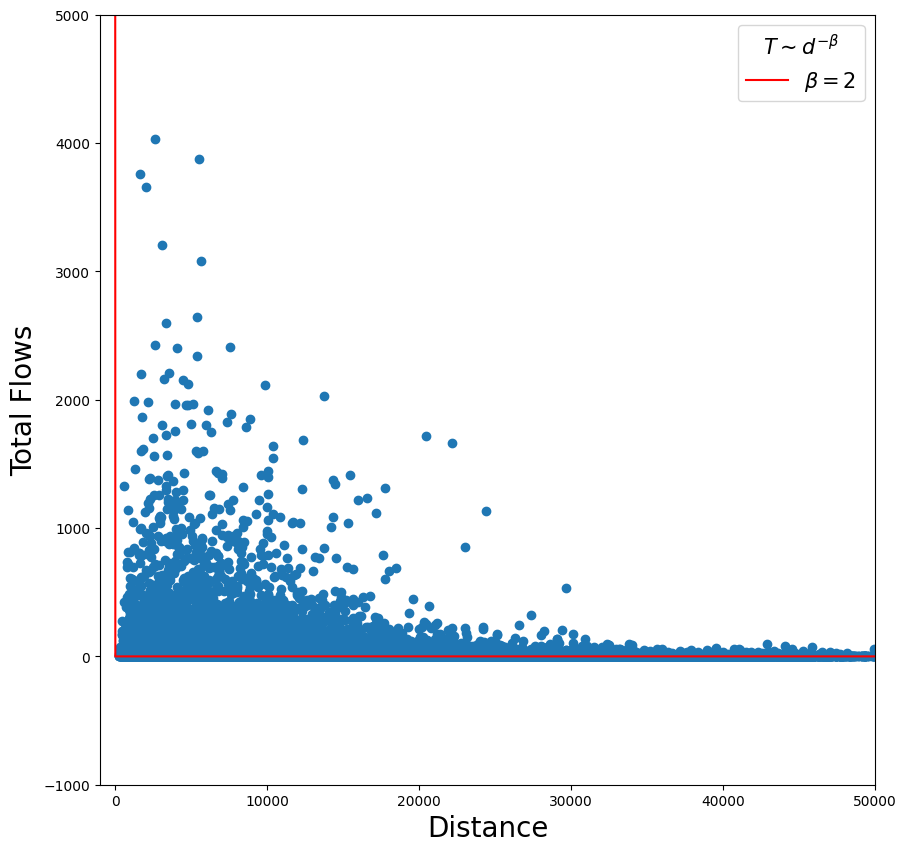

In [16]:
#first plot the Total commuter flows denoted by T against distance denoted by d
#and then fit a model line T ~ d^-beta with beta=2

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = flow_OD["distance"], y=flow_OD["flows"])
#line plot
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "$\\beta=2$")
#add a legend
ax.legend(title = "$T \\sim d^{-\\beta}$", fontsize = 15, title_fontsize=15)
#axis limits
ax.set_xlim([-1000,50000])
ax.set_ylim([-1000, 5000])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Calculate all models to view RMSE and R-squared (using production anyway )

In [61]:
#set out all the fomrulas
formula1 = "flows ~ np.log(population) + np.log(jobs) + np.log(distance) -1"
formula2 = "flows ~ station_origin + np.log(jobs) + np.log(distance) -1"
formula3 = "flows ~ np.log(population) + station_destination + np.log(distance) -1"
formula4 = "flows ~ station_origin + station_destination + np.log(distance) -1"
formula5 = "flows ~ np.log(population) + np.log(jobs) + distance -1"
formula6 = "flows ~ station_origin + np.log(jobs) + distance -1"
formula7 = "flows ~ np.log(population) + station_destination + distance -1"
formula8 = "flows ~ station_origin + station_destination + distance -1"

#create a list of all the formulas
formulas = [formula1, formula2, formula3, formula4, 
            formula5, formula6, formula7, formula8]

#list the models name
models = ["uncosim_pow", "prodsim_pow", "attrsim_pow", "doublesim_pow",
         "uncosim_exp", "prodsim_exp", "attrsim_exp", "doublesim_exp"]

#create a set of tuples to store whether a paramater
#will be in the model or not
model_params = [(True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True),
               (True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True)]

#create an ampty dictionary to store the results
results = {"Model":models,
          "R2": [],
          "RMSE": [],
          "Alpha":[],
          "Gamma":[],
          "Beta":[]}

#loop over each formula
for i, formula in enumerate(formulas):
    
    #run the specified model
    sim = smf.glm(formula = formula, 
                 data = flow_OD,
                 family = sm.families.Poisson()).fit()
    #clauclate the estimates
    flow_OD[models[i]] = sim.mu
    
    #if the alpha paramater is true
    if model_params[i][0] == True:
        
        #if there are three params then it will be 
        #in the third position
        if sum(model_params[i]) == 3:
            
            results["Alpha"].append(sim.params[-3])
            
        #otherwise it will be in the second paramater
        else:
            results["Alpha"].append(sim.params[-2])
            
    #if not then just append nan
    else:
        results["Alpha"].append(np.nan) 
    
    #if the gamma paramater is True
    #then it will always be the second paramater
    if model_params[i][1] == True:
        results["Gamma"].append(sim.params[-2])
    #otherwise add nan
    else:
        results["Gamma"].append(np.nan)
    
    #add the beta to the results (always will be there)
    results["Beta"].append(sim.params[-1])
        
    #add the metrics to the results dictionary
    results["R2"].append(CalcRSquared(flow_OD["flows"],flow_OD[models[i]]))
    results["RMSE"].append(CalcRMSE(flow_OD["flows"],flow_OD[models[i]]))

#create a dataframe from the results
results = pd.DataFrame(results)
#print the results
results

,Model,R2,RMSE,Alpha,Gamma,Beta
0,uncosim_pow,0.246443,114.260,0.616202,0.650897,-0.815905
1,prodsim_pow,0.388269,102.893,NaN,0.768616,-0.878119
2,attrsim_pow,0.349942,106.012,0.745118,NaN,-0.635148
3,doublesim_pow,0.407697,101.334,NaN,NaN,-0.909632
4,uncosim_exp,0.173430,120.845,0.245243,0.344050,-0.000135
5,prodsim_exp,0.468066,96.263,NaN,0.755222,-0.000153
6,attrsim_exp,0.399960,102.168,0.714555,NaN,-0.000100
7,doublesim_exp,0.497890,93.397,NaN,NaN,-0.000154


Handy to have the log columns for future use

In [17]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    flow_OD[f"log_{x}"] = np.log(flowdata[x])
    log_x_vars.append(f"log_{x}")

The total flows before calibration

In [169]:
cdatasubmat = pd.pivot_table(flow_OD, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


Calibrating using neg exponential and production constrained 

In [170]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = "flows ~ station_origin + np.log(jobs) + distance -1"
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=flow_OD, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Mon, 06 May 2024   Deviance:                   1.6477e+06
Time:                        01:14:51   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Viewing the flow_OD data

In [207]:
flow_OD.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


Preparation for calibrating the initial model 

In [208]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flow_OD = flow_OD.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flow_OD.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flow_OD = flow_OD.merge(D_j, on = "station_destination", how = "left" )

In [209]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
flow_OD = flow_OD.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flow_OD.drop(columns = ["coef"], inplace = True)
flow_OD.head()

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322


In [210]:
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

In [211]:
alpha_i.head()

station_origin[Abbey Road]      -2.914322
station_origin[Acton Central]   -1.162092
station_origin[Acton Town]      -1.613081
station_origin[Aldgate]         -2.943047
station_origin[Aldgate East]    -2.854752
dtype: float64

In [213]:
gamma

0.7552215895693725

In [214]:
beta

0.00015316619346309487

The first calibration to view the flows, named flow_OD3

In [215]:
flow_OD["prodsimest1"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["jobs"] )
                                 - beta*flow_OD["distance"])

In [216]:
#first round the estimates
flow_OD["prodsimest1"] = round(flow_OD["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flow_OD3 = flow_OD.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_OD3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


Compared to uncalibrated, some flows are lost here, maybe a goodness of fit issue

In [26]:
cdatasubmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


To view the new column added

In [218]:
flow_OD.head()

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,78.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,99.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,56.0


In [219]:
CalcRSquared(flow_OD["flows"], flow_OD["prodsimest1"])

0.46806484435428586

In [220]:
CalcRMSE(flow_OD["flows"], flow_OD["prodsimest1"])

96.263

Scenario A

In [221]:
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val = 29386
    else:
        val = row["jobs"]
    return val
        
flow_OD["Dj3_destsalScenario"] = flow_OD.apply(new_sal, axis =1)
flow_OD.head(10)

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,alpha_i,prodsimest1,Dj3_destsalScenario
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,78.0,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,1.0,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,4.0,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,99.0,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,56.0,15428
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208,-2.914322,4.0,1208
6,Abbey Road,Custom House,0,599,845,3824.855630,599,845,-2.914322,5.0,845
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,599,1748,-2.914322,4.0,1748
8,Abbey Road,Cyprus,7,599,850,6532.099618,599,850,-2.914322,3.0,850
9,Abbey Road,Devons Road,1,599,611,3958.324171,599,611,-2.914322,4.0,611


Calculating new values for the scenario

In [229]:
#calculate some new Dj^gamma and d_ij^beta values
Dj2_gamma = flow_OD["jobs"]**gamma
dist_beta = np.exp((-beta)*flow_OD["distance"])
#calcualte the first stage of the Ai values
flow_OD["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

To see if our first model calibration matches with the calibrating for future reference, there should be no difference. 

In [236]:
#to check everything works, recreate the original estimates
flow_OD["prodsimest3"] = flow_OD["A_i"]*flow_OD["O_i"]*Dj2_gamma*dist_beta
#round
flow_OD["prodsimest3"] = round(flow_OD["prodsimest3"])
#check
flow_OD[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,78.0,78.0
1,1.0,1.0
2,4.0,4.0
3,99.0,99.0
4,56.0,56.0
...,...,...
61408,99.0,99.0
61409,295.0,295.0
61410,36.0,36.0
61411,125.0,125.0


Now add in for scenario A function (the change in jobs for Canary wharf)

In [237]:

flow_OD["prodsimest4"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["Dj3_destsalScenario"])
                                - beta*flow_OD["distance"])
#round
flow_OD["prodsimest4"] = round(flow_OD["prodsimest4"],0)

In [241]:
flow_OD[["prodsimest3", "prodsimest4"]]

,prodsimest3,prodsimest4
0,78.0,78.0
1,1.0,1.0
2,4.0,4.0
3,99.0,59.0
4,56.0,56.0
...,...,...
61408,99.0,99.0
61409,295.0,295.0
61410,36.0,36.0
61411,125.0,125.0


In [263]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = flow_OD["jobs"]**gamma

#calcualte the first stage of the Ai values
flow_OD["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"Ai2"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [264]:
#to check everything works, recreate the original estimates
flow_OD["prodsimest9"] = flow_OD["Ai2"]*flow_OD["O_i"]*Dj3_gamma*dist_beta
#round
flow_OD["prodsimest9"] = round(flow_OD["prodsimest9"])
flow_OD[["prodsimest3", "prodsimest9"]]


,prodsimest3,prodsimest9
0,78.0,78.0
1,1.0,1.0
2,4.0,4.0
3,99.0,99.0
4,56.0,56.0
...,...,...
61408,99.0,99.0
61409,295.0,295.0
61410,36.0,36.0
61411,125.0,125.0


In [269]:
#calculate some new Dj^gamma and d_ij^beta values
Dj4_gamma = flow_OD["Dj3_destsalScenario"]**gamma
#calcualte the first stage of the Ai values
flow_OD["Ai1"] = Dj4_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"Ai3"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [271]:
#to check everything works, recreate the original estimates
flow_OD["prodsimest10"] = flow_OD["Ai3"]*flow_OD["O_i"]*Dj4_gamma*dist_beta
#round
flow_OD["prodsimest10"] = round(flow_OD["prodsimest10"])


In [260]:
flow_OD[["prodsimest3", "prodsimest10"]]

,prodsimest3,prodsimest10
0,78.0,83.0
1,1.0,2.0
2,4.0,4.0
3,99.0,63.0
4,56.0,60.0
...,...,...
61408,99.0,107.0
61409,295.0,320.0
61410,36.0,39.0
61411,125.0,135.0


In [254]:
flow_OD3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [253]:
#show the results in a pivot table of attrsimest4
#called cdatasubmat8
cdatasubmat8 = flow_OD.pivot_table(values ="prodsimest10", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#show the matrix
cdatasubmat8

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


There should not be an increase in flows there is here by +50 

Change in flows

In [273]:
change_A = cdatasubmat8 - flow_OD3

change_A

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,6.0
Aldgate,NaN,NaN,0.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,...,0.0,NaN,1.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0
Aldgate East,NaN,NaN,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-7.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0


Scenario B

In [40]:
betaB1 = beta*1.5
betaB2 = beta*1.33

In [274]:
betaB2

0.0002037110373059162

In [275]:
betaB1

0.0002297492901946423

In [278]:

flow_OD["prodsimestB1"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["jobs"])
                                - betaB1*flow_OD["distance"])
#round
flow_OD["prodsimestB1"] = round(flow_OD["prodsimestB1"],0)
#now we can convert the pivot table into a matrix
#called cdatasubmat7
SCENB1 = flow_OD.pivot_table(values ="prodsimestB1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
SCENB1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,457.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,677.0
Acton Town,NaN,NaN,NaN,4.0,3.0,NaN,9.0,0.0,NaN,5.0,...,4.0,1.0,0.0,12.0,NaN,0.0,NaN,0.0,NaN,1722.0
Aldgate,NaN,NaN,0.0,NaN,33.0,NaN,NaN,0.0,NaN,21.0,...,0.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2055.0
Aldgate East,NaN,NaN,0.0,36.0,NaN,NaN,0.0,0.0,NaN,22.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,12.0,17.0,NaN,NaN,NaN,NaN,8.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1662.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0
Woodside Park,NaN,NaN,0.0,5.0,5.0,NaN,0.0,NaN,NaN,11.0,...,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1017.0


In [279]:
#calculate some new Dj^gamma and d_ij^beta values
dist_beta1 = np.exp((-betaB1)*flow_OD["distance"])
#calcualte the first stage of the Ai values
flow_OD["Ai1"] = Dj3_gamma * dist_beta1
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_iB1"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [280]:
flow_OD

,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,alpha_i,prodsimest1,...,prodsimest10,Ai3_x,Ai3_y,Ai3_x,Ai2_y,Ai2,Ai3_y,Ai3,prodsimestB1,A_iB1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,78.0,...,83.0,0.000097,0.000097,0.000097,0.000091,0.000091,0.000097,0.000097,42.0,0.000119
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,1.0,...,2.0,0.000097,0.000097,0.000097,0.000091,0.000091,0.000097,0.000097,1.0,0.000119
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,4.0,...,4.0,0.000097,0.000097,0.000097,0.000091,0.000091,0.000097,0.000097,3.0,0.000119
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,99.0,...,63.0,0.000097,0.000097,0.000097,0.000091,0.000091,0.000097,0.000097,67.0,0.000119
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,56.0,...,60.0,0.000097,0.000097,0.000097,0.000091,0.000091,0.000097,0.000097,47.0,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,7892,3342,0.518041,99.0,...,107.0,0.000230,0.000230,0.000230,0.000213,0.000213,0.000230,0.000230,35.0,0.000437
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,7892,5487,0.518041,295.0,...,320.0,0.000230,0.000230,0.000230,0.000213,0.000213,0.000230,0.000230,152.0,0.000437
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,7892,400,0.518041,36.0,...,39.0,0.000230,0.000230,0.000230,0.000213,0.000213,0.000230,0.000230,17.0,0.000437
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,7892,893,0.518041,125.0,...,135.0,0.000230,0.000230,0.000230,0.000213,0.000213,0.000230,0.000230,83.0,0.000437


In [281]:
#to check everything works, recreate the original estimates
flow_OD["SB1"] = flow_OD["A_iB1"]*flow_OD["O_i"]*Dj3_gamma*dist_beta1
#round
flow_OD["SB1"] = round(flow_OD["SB1"])


In [282]:
#show the results in a pivot table of attrsimest4
#called cdatasubmat8
SB1 = flow_OD.pivot_table(values ="SB1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#show the matrix
SB1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,8.0,7.0,NaN,20.0,0.0,NaN,10.0,...,9.0,2.0,1.0,26.0,NaN,0.0,NaN,0.0,NaN,3745.0
Aldgate,NaN,NaN,1.0,NaN,47.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,51.0,NaN,NaN,0.0,0.0,NaN,30.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,36.0,50.0,NaN,NaN,NaN,NaN,22.0,...,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,1.0,16.0,15.0,NaN,0.0,NaN,NaN,32.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3089.0


Again, another slight in overall flows, this should not happen in the data but I havent identified any issues in the process of calibration

In [283]:
change_B1 = SB1 - flow_OD3

change_B1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,5.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-3.0
Acton Town,NaN,NaN,NaN,-5.0,-6.0,NaN,6.0,0.0,NaN,-6.0,...,-4.0,-1.0,-1.0,6.0,NaN,0.0,NaN,-1.0,NaN,1.0
Aldgate,NaN,NaN,0.0,NaN,10.0,NaN,NaN,0.0,NaN,2.0,...,-1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,-10.0
Aldgate East,NaN,NaN,0.0,11.0,NaN,NaN,0.0,0.0,NaN,1.0,...,-1.0,0.0,-2.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,-1.0,-5.0,-2.0,NaN,NaN,NaN,NaN,-8.0,...,-1.0,NaN,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,-2.0
Woodgrange Park,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
Woodside Park,NaN,NaN,-1.0,-3.0,-4.0,NaN,0.0,NaN,NaN,0.0,...,-2.0,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-11.0


In [371]:
flow_OD["prodsimestB2"] = np.exp(flow_OD["alpha_i"]+gamma*np.log(flow_OD["jobs"])
                                - betaB2*flow_OD["distance"])
#round
flow_OD["prodsimestB2"] = round(flow_OD["prodsimestB2"],0)
#now we can convert the pivot table into a matrix
#called cdatasubmat7
SCENB2 = flow_OD.pivot_table(values ="prodsimestB2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#display the results
SCENB2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,496.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,817.0
Acton Town,NaN,NaN,NaN,5.0,5.0,NaN,11.0,0.0,NaN,7.0,...,6.0,1.0,1.0,14.0,NaN,0.0,NaN,0.0,NaN,2215.0
Aldgate,NaN,NaN,1.0,NaN,35.0,NaN,NaN,0.0,NaN,23.0,...,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2294.0
Aldgate East,NaN,NaN,1.0,37.0,NaN,NaN,0.0,0.0,NaN,24.0,...,1.0,0.0,1.0,1.0,NaN,0.0,NaN,0.0,NaN,2507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,18.0,25.0,NaN,NaN,NaN,NaN,12.0,...,0.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2351.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378.0
Woodside Park,NaN,NaN,1.0,8.0,8.0,NaN,0.0,NaN,NaN,15.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1452.0


In [374]:
#calculate some new Dj^gamma and d_ij^beta values
dist_beta2 = np.exp((-betaB2)*flow_OD["distance"])
#calcualte the first stage of the Ai values
flow_OD["Ai1"] = Dj3_gamma * dist_beta2
#now do the sum over all js bit
A_i = pd.DataFrame(flow_OD.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_iB2"}, inplace=True)
#and write the A_i values back into the dataframe
flow_OD = flow_OD.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [375]:
#to check everything works, recreate the original estimates
flow_OD["SB2"] = flow_OD["A_iB2"]*flow_OD["O_i"]*Dj3_gamma*dist_beta2
#round
flow_OD["SB2"] = round(flow_OD["SB2"])

In [376]:
#show the results in a pivot table of attrsimest4
#called cdatasubmat8
SB2 = flow_OD.pivot_table(values ="SB2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

#show the matrix
SB2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1225.0
Acton Town,NaN,NaN,NaN,9.0,9.0,NaN,18.0,0.0,NaN,12.0,...,10.0,2.0,1.0,24.0,NaN,0.0,NaN,0.0,NaN,3742.0
Aldgate,NaN,NaN,1.0,NaN,43.0,NaN,NaN,0.0,NaN,29.0,...,1.0,NaN,2.0,1.0,NaN,0.0,NaN,0.0,NaN,2875.0
Aldgate East,NaN,NaN,1.0,47.0,NaN,NaN,0.0,0.0,NaN,30.0,...,1.0,0.0,2.0,1.0,NaN,1.0,NaN,0.0,NaN,3159.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,38.0,52.0,NaN,NaN,NaN,NaN,25.0,...,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4863.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,1.0,17.0,16.0,NaN,0.0,NaN,NaN,32.0,...,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3097.0


In [377]:
change_B2 = SB2 - flow_OD3
change_B2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,5.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-1.0
Acton Town,NaN,NaN,NaN,-4.0,-4.0,NaN,4.0,0.0,NaN,-4.0,...,-3.0,-1.0,-1.0,4.0,NaN,0.0,NaN,-1.0,NaN,-2.0
Aldgate,NaN,NaN,0.0,NaN,6.0,NaN,NaN,0.0,NaN,2.0,...,-1.0,NaN,0.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,-10.0
Aldgate East,NaN,NaN,0.0,7.0,NaN,NaN,0.0,0.0,NaN,1.0,...,-1.0,0.0,-1.0,-1.0,NaN,0.0,NaN,-1.0,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,-3.0,0.0,NaN,NaN,NaN,NaN,-5.0,...,-1.0,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0
Woodgrange Park,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0
Woodside Park,NaN,NaN,-1.0,-2.0,-3.0,NaN,0.0,NaN,NaN,0.0,...,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,-3.0


In [378]:
changeB2_byAll = change_B2.loc['All']
changeB2_byAll = changeB2_byAll.to_frame(name='Flows_B2')
changeB2_byAll = changeB2_byAll.sort_values(by='Flows_B2', ascending=False)
top_15_changeB2_byAll = changeB2_byAll.head(20)
top_15_changeB2_byAll

,Flows_B2
station_destination,
Harrow-on-the-Hill,934.0
Romford,772.0
Wembley Park,678.0
Northwick Park,590.0
Chalfont & Latimer,435.0
West Ham,421.0
Northwood,410.0
Chorleywood,396.0
Rickmansworth,377.0


In [379]:
changeB2_byAll = change_B2.loc['All']
changeB2_byAll = changeB2_byAll.to_frame(name='Flows_B2')
changeB2_byAllNeg = changeB2_byAll.sort_values(by='Flows_B2', ascending=True)
top_15_changeB2_byAllNeg = changeB2_byAllNeg.head(20)
top_15_changeB2_byAllNeg

,Flows_B2
station_destination,
Liverpool Street,-2772.0
Stratford,-1721.0
Bank and Monument,-978.0
Highbury & Islington,-828.0
Canary Wharf,-814.0
Paddington,-786.0
Vauxhall,-627.0
Canada Water,-589.0
Shepherd's Bush,-546.0


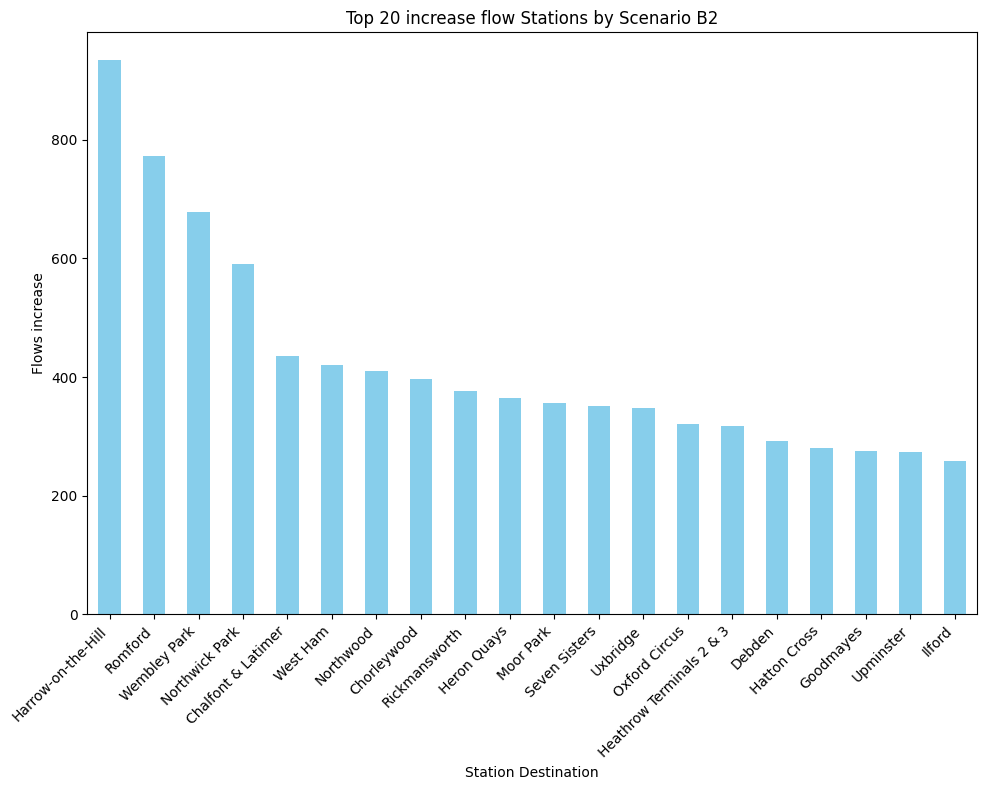

In [380]:
# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
top_15_changeB2_byAll['Flows_B2'].plot(kind='bar', color='skyblue')

plt.title('Top 20 increase flow Stations by Scenario B2')  # Chart title
plt.xlabel('Station Destination')  # X-axis label
plt.ylabel('Flows increase')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


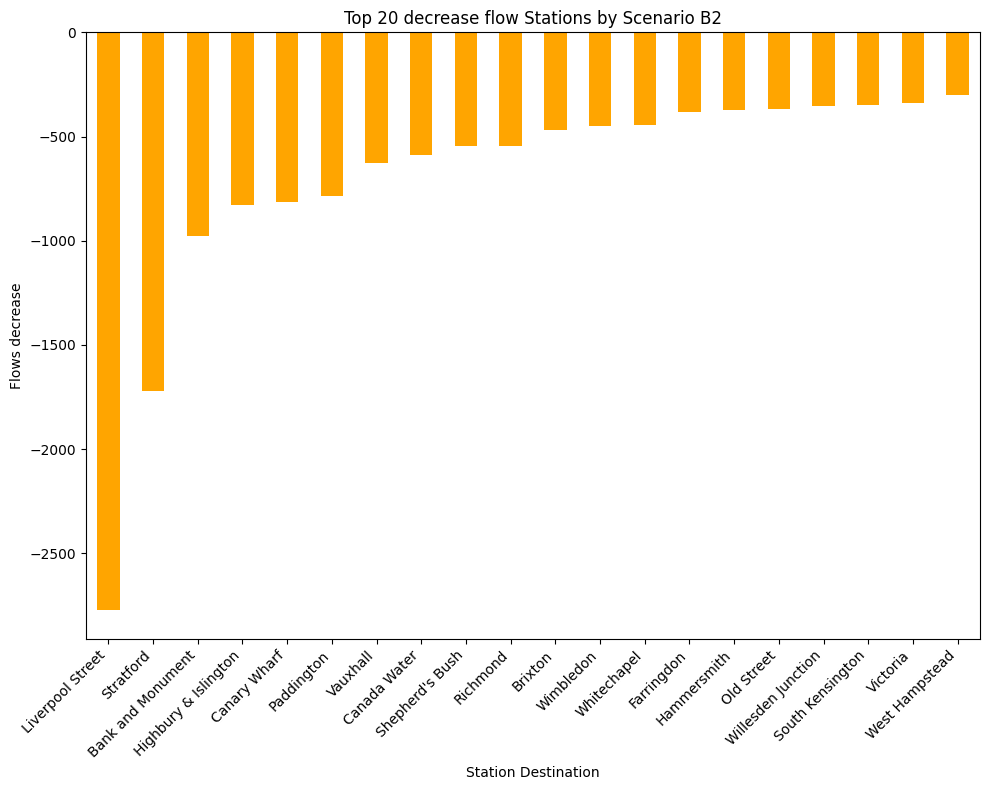

In [382]:
# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
top_15_changeB2_byAllNeg['Flows_B2'].plot(kind='bar', color='orange')

plt.title('Top 20 decrease flow Stations by Scenario B2')  # Chart title
plt.xlabel('Station Destination')  # X-axis label
plt.ylabel('Flows decrease')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


In [333]:
bakerloo = ["Baker Street", "Charing Cross", "Edgware Road", "Elephant & Castle", "Embankment", "Harlesden", "Harrow & Wealdstone", "Kensal Green", "Kenton", "Kilburn Park", "Lambeth North", "Maida Vale", "Marylebone", "North Wembley", "Oxford Circus", "Paddington", "Piccadilly Circus", "Queen's Park", "Regent's Park", "South Kenton", "Stonebridge Park", "Warwick Avenue", "Waterloo", "Wembley Central", "Willesden Junction"],

central = ["Bank and Monument", "Barkingside", "Bethnal Green", "Bond Street", "Buckhurst Hill", "Chancery Lane", "Chigwell", "Debden", "Ealing Broadway", "East Acton", "Epping", "Fairlop", "Gants Hill", "Grange Hill", "Greenford", "Hainault", "Hanger Lane", "Holborn", "Holland Park", "Lancaster Gate", "Leyton", "Leytonstone", "Liverpool Street", "Loughton", "Marble Arch", "Mile End", "Newbury Park", "North Acton", "Northolt", "Notting Hill Gate", "Oxford Circus", "Perivale", "Queensway", "Redbridge", "Roding Valley", "Ruislip Gardens", "Shepherd's Bush", "Snaresbrook", "South Ruislip", "South Woodford", "St. Paul's", "Stratford", "Theydon Bois", "Tottenham Court Road", "Wanstead", "West Acton", "West Ruislip", "White City", "Woodford"],
    
circle = ["Aldgate", "Baker Street", "Barbican", "Bayswater", "Blackfriars", "Cannon Street", "Edgware Road", "Embankment", "Euston Square", "Farringdon", "Gloucester Road", "Goldhawk Road", "Great Portland Street", "Hammersmith", "High Street Kensington", "King's Cross St. Pancras", "Ladbroke Grove", "Latimer Road", "Liverpool Street", "Mansion House", "Bank and Monument", "Moorgate", "Notting Hill Gate", "Paddington", "Royal Oak", "Shepherd's Bush Market", "Sloane Square", "South Kensington", "St. James's Park", "Temple", "Tower Hill", "Victoria", "Westbourne Park", "Westminster", "Wood Lane"],
    
district = ["Acton Town", "Aldgate East", "Barking", "Barons Court", "Bayswater", "Becontree", "Blackfriars", "Bow Church", "Bow Road", "Bromley-by-Bow", "Cannon Street", "Chiswick Park", "Dagenham East", "Dagenham Heathway", "Ealing Broadway", "Ealing Common", "Earl's Court", "East Ham", "East Putney", "Edgware Road", "Elm Park", "Embankment", "Fulham Broadway", "Gloucester Road", "Gunnersbury", "Hammersmith", "High Street Kensington", "Hornchurch", "Kensington", "Kew Gardens", "Mansion House", "Bank and Monument", "Notting Hill Gate", "Paddington", "Parsons Green", "Plaistow", "Putney Bridge", "Ravenscourt Park", "Richmond", "Sloane Square", "South Kensington", "Southfields", "St. James's Park", "Stamford Brook", "Stepney Green", "Temple", "Tower Hill", "Turnham Green", "Upminster", "Upminster Bridge", "Upney", "Upton Park", "Victoria", "West Brompton", "West Ham", "West Kensington", "Westminster", "Whitechapel", "Wimbledon", "Wimbledon Park"],
    
hammersmithcity = ["Aldgate East", "Baker Street", "Barbican", "Barking", "Bow Road", "Bromley-by-Bow", "East Ham", "Edgware Road", "Euston Square", "Farringdon", "Goldhawk Road", "Great Portland Street", "Hammersmith", "King's Cross St. Pancras", "Ladbroke Grove", "Latimer Road", "Liverpool Street", "Mile End", "Moorgate", "Paddington", "Plaistow", "Royal Oak", "Shepherd's Bush Market", "Stepney Green", "Upton Park", "West Ham", "Westbourne Park", "Whitechapel", "Wood Lane"],
    
metropolitan = ["Aldgate", "Amersham", "Baker Street", "Barbican", "Chalfont & Latimer", "Chesham", "Chorleywood", "Croxley", "Eastcote", "Euston Square", "Farringdon", "Finchley Road", "Great Portland Street", "Harrow-on-the-Hill", "Hillingdon", "Ickenham", "King's Cross St. Pancras", "Liverpool Street", "Moor Park", "Moorgate", "North Harrow", "Northwick Park", "Northwood", "Northwood Hills", "Pinner", "Preston Road", "Rickmansworth", "Ruislip", "Ruislip Manor", "Uxbridge", "Watford", "Wembley Park", "West Harrow"],
    
northern = ["Angel", "Archway", "Balham", "Bank and Monument",  "Belsize Park", "Borough", "Brent Cross", "Burnt Oak", "Camden Town", "Chalk Farm", "Charing Cross", "Clapham Common", "Clapham North", "Clapham South", "Colindale", "Colliers Wood", "East Finchley", "Edgware", "Elephant & Castle", "Embankment", "Euston", "Finchley Central", "Golders Green", "Goodge Street", "Hampstead", "Hendon Central", "High Barnet", "Highgate", "Kennington", "Kentish Town", "King's Cross St. Pancras", "Leicester Square", "London Bridge", "Mill Hill East", "Moorgate", "Morden", "Mornington Crescent",  "Old Street", "Oval", "South Wimbledon", "Stockwell", "Tooting Bec", "Tooting Broadway", "Tottenham Court Road", "Totteridge & Whetstone", "Tufnell Park", "Warren Street", "Waterloo", "West Finchley", "Woodside Park"],
    
overground = ["Acton Central", "Anerley", "Barking", "Bethnal Green", "Blackhorse Road", "Brockley", "Brondesbury", "Brondesbury Park", "Bruce Grove", "Bush Hill Park", "Bushey", "Caledonian Road & Barnsbury", "Cambridge Heath", "Camden Road", "Canada Water", "Canonbury", "Carpenders Park", "Cheshunt", "Chingford", "Clapham High Street", "Clapham Junction", "Clapton", "Crouch Hill", "Crystal Palace", "Dalston Junction", "Dalston Kingsland", "Denmark Hill", "Edmonton Green", "Emerson Park", "Enfield Town", "Euston", "Finchley Road & Frognal", "Forest Hill", "Gospel Oak", "Gunnersbury", "Hackney Central", "Hackney Downs", "Hackney Wick", "Haggerston", "Hampstead Heath", "Harlesden", "Harringay Green Lanes", "Harrow & Wealdstone", "Hatch End", "Headstone Lane", "Highams Park", "Highbury & Islington", "Homerton", "Honor Oak Park", "Hoxton", "Imperial Wharf", "Kensal Green", "Kensal Rise", "Kensington", "Kentish Town West", "Kenton", "Kew Gardens", "Kilburn High Road", "Leyton Midland Road", "Leytonstone High Road", "Liverpool Street", "London Fields", "New Cross", "New Cross Gate", "North Wembley", "Norwood Junction", "Peckham Rye", "Penge West", "Queen's Park", "Queens Road Peckham", "Rectory Road", "Richmond", "Romford", "Rotherhithe", "Seven Sisters", "Shadwell", "Shepherd's Bush", "Shoreditch High Street", "Silver Street", "South Acton", "South Hampstead", "South Kenton", "South Tottenham", "Southbury", "St James Street", "Stamford Hill", "Stoke Newington", "Stonebridge Park", "Stratford", "Surrey Quays", "Sydenham", "Theobalds Grove", "Turkey Street", "Upminster", "Upper Holloway", "Walthamstow Central", "Walthamstow Queens Road", "Wandsworth Road", "Wanstead Park", "Wapping", "Watford High Street", "Watford Junction", "Wembley Central", "West Brompton", "West Croydon", "West Hampstead", "White Hart Lane", "Whitechapel", "Willesden Junction", "Wood Street", "Woodgrange Park"],
    
piccadilly = ["Acton Town", "Alperton", "Arnos Grove", "Arsenal", "Barons Court", "Boston Manor", "Bounds Green", "Caledonian Road", "Cockfosters", "Covent Garden", "Ealing Common", "Earl's Court", "Eastcote", "Finsbury Park", "Gloucester Road", "Green Park", "Hammersmith", "Hatton Cross", "Heathrow Terminal 4", "Heathrow Terminal 5",  "Hillingdon", "Holborn", "Holloway Road", "Hounslow Central", "Hounslow East", "Hounslow West", "Hyde Park Corner", "Ickenham", "King's Cross St. Pancras", "Knightsbridge", "Leicester Square", "Manor House", "North Ealing", "Northfields", "Oakwood", "Osterley", "Park Royal", "Piccadilly Circus", "Rayners Lane", "Ruislip", "Ruislip Manor", "Russell Square", "South Ealing", "South Harrow", "South Kensington", "Southgate", "Sudbury Hill", "Sudbury Town", "Turnham Green", "Turnpike Lane", "Uxbridge", "Wood Green"],
    
victoria = ["Blackhorse Road", "Brixton", "Euston", "Finsbury Park", "Green Park", "Highbury & Islington", "King's Cross St. Pancras", "Oxford Circus", "Pimlico", "Seven Sisters", "Stockwell", "Tottenham Hale", "Vauxhall", "Victoria", "Walthamstow Central", "Warren Street"],
    
waterloocity = ["Bank and Monument", "Waterloo"],
    
jubilee = ["Baker Street", "Bermondsey", "Bond Street", "Canada Water", "Canary Wharf", "Canning Town", "Canons Park", "Dollis Hill", "Finchley Road", "Green Park", "Kilburn", "Kingsbury", "London Bridge", "Neasden", "North Greenwich", "Queensbury", "Southwark", "St. John's Wood", "Stanmore", "Stratford", "Swiss Cottage", "Waterloo", "Wembley Park", "West Ham", "West Hampstead", "Westminster", "Willesden Green"]


In [297]:
bakerloo

(['Baker Street',
  'Charing Cross',
  'Edgware Road',
  'Elephant & Castle',
  'Embankment',
  'Harlesden',
  'Harrow & Wealdstone',
  'Kensal Green',
  'Kenton',
  'Kilburn Park',
  'Lambeth North',
  'Maida Vale',
  'Marylebone',
  'North Wembley',
  'Oxford Circus',
  'Paddington',
  'Piccadilly Circus',
  'Queen’s Park',
  'Regent’s Park',
  'South Kenton',
  'Stonebridge Park',
  'Warwick Avenue',
  'Waterloo',
  'Wembley Central',
  'Willesden Junction'],)

In [293]:
print(change_B1.columns)

Index(['Abbey Road', 'Acton Central', 'Acton Town', 'Aldgate', 'Aldgate East',
       'All Saints', 'Alperton', 'Amersham', 'Anerley', 'Angel',
       ...
       'Wimbledon', 'Wimbledon Park', 'Wood Green', 'Wood Lane', 'Wood Street',
       'Woodford', 'Woodgrange Park', 'Woodside Park', 'Woolwich Arsenal',
       'All'],
      dtype='object', name='station_destination', length=399)


In [350]:
changeB1_byAll = change_B1.loc['All']
changeB1_byAll = changeB1_byAll.to_frame(name='Flows_B1')
changeB1_byAll = changeB1_byAll.sort_values(by='Flows_B1', ascending=False)
top_15_changeB1_byAll = changeB1_byAll.head(20)
top_15_changeB1_byAll

,Flows_B1
station_destination,
Harrow-on-the-Hill,1481.0
Wembley Park,1135.0
Romford,1134.0
Northwick Park,956.0
West Ham,699.0
Seven Sisters,677.0
Chalfont & Latimer,623.0
Northwood,593.0
Chorleywood,539.0


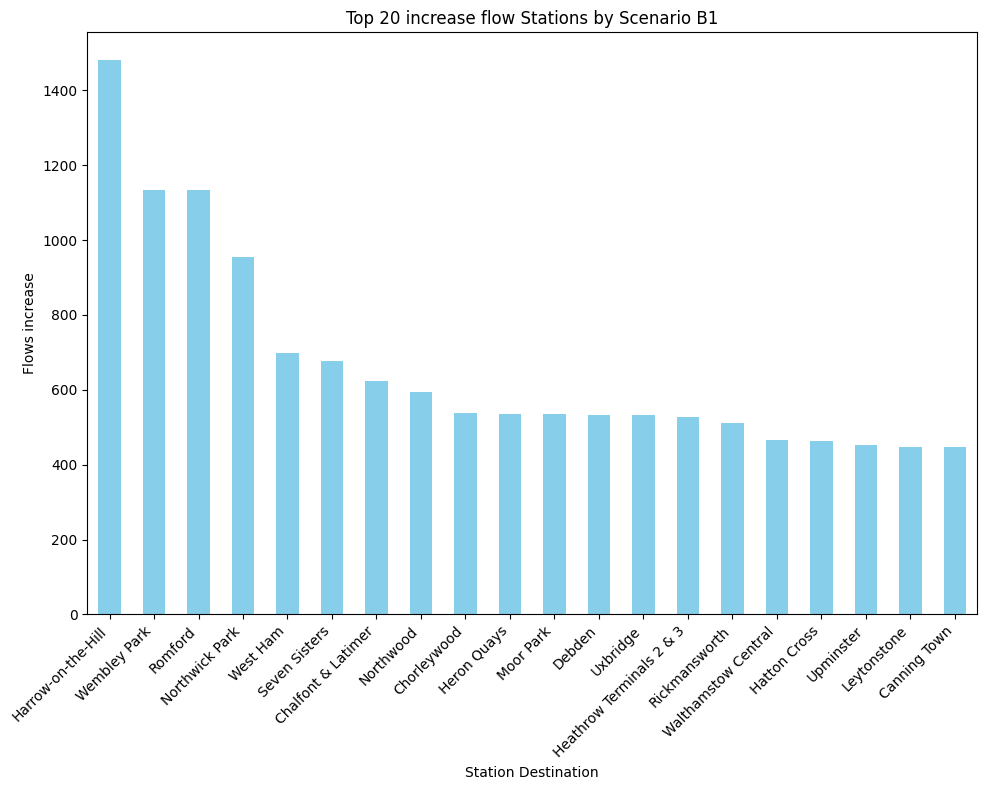

In [361]:
# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
top_15_changeB1_byAll['Flows_B1'].plot(kind='bar', color='skyblue')

plt.title('Top 20 increase flow Stations by Scenario B1')  # Chart title
plt.xlabel('Station Destination')  # X-axis label
plt.ylabel('Flows increase')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


In [351]:
changeB1_byAll = change_B1.loc['All']
changeB1_byAll = changeB1_byAll.to_frame(name='Flows_B1')
changeB1_byAllNeg = changeB1_byAll.sort_values(by='Flows_B1', ascending=True)
top_15_changeB1_byAllNeg = changeB1_byAllNeg.head(20)
top_15_changeB1_byAllNeg

,Flows_B1
station_destination,
Liverpool Street,-4385.0
Stratford,-2496.0
Bank and Monument,-1881.0
Highbury & Islington,-1307.0
Paddington,-1278.0
Canary Wharf,-1221.0
Canada Water,-1038.0
Vauxhall,-942.0
Whitechapel,-849.0


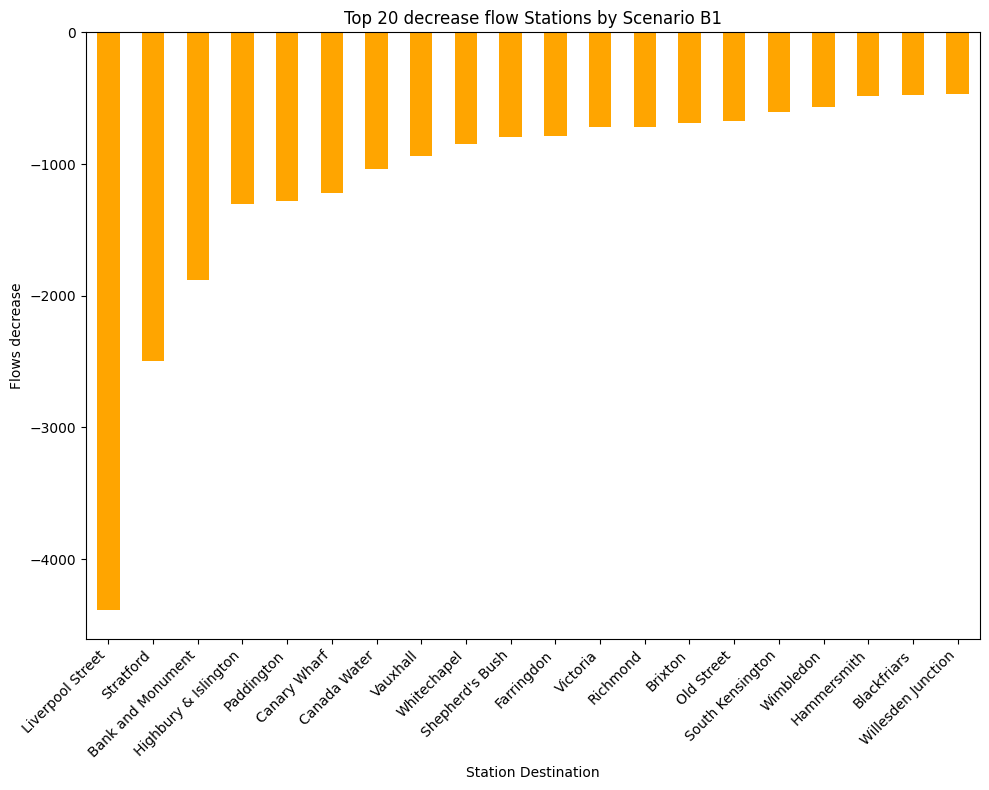

In [362]:
# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
top_15_changeB1_byAllNeg['Flows_B1'].plot(kind='bar', color='orange')

plt.title('Top 20 decrease flow Stations by Scenario B1')  # Chart title
plt.xlabel('Station Destination')  # X-axis label
plt.ylabel('Flows decrease')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


In [ ]:
# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
top_15_changeA1_byAll['Flows_A'].plot(kind='bar', color='skyblue')

plt.title('Top 20 Stations by Scenario A')  # Chart title
plt.xlabel('Station Destination')  # X-axis label
plt.ylabel('Flows increase')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


In [357]:
changeA1_byAll = change_A.loc['All']
changeA1_byAll = changeA1_byAll.to_frame(name='Flows_A')
changeA1_byAll = changeA1_byAll.sort_values(by='Flows_A', ascending=False)
top_15_changeA1_byAll = changeA1_byAll.head(20)
top_15_changeA1_byAll

,Flows_A
station_destination,
Bank and Monument,1648.0
Stratford,1467.0
Canning Town,696.0
Liverpool Street,522.0
Oxford Circus,339.0
London Bridge,302.0
King's Cross St. Pancras,282.0
West Ham,281.0
Heron Quays,280.0


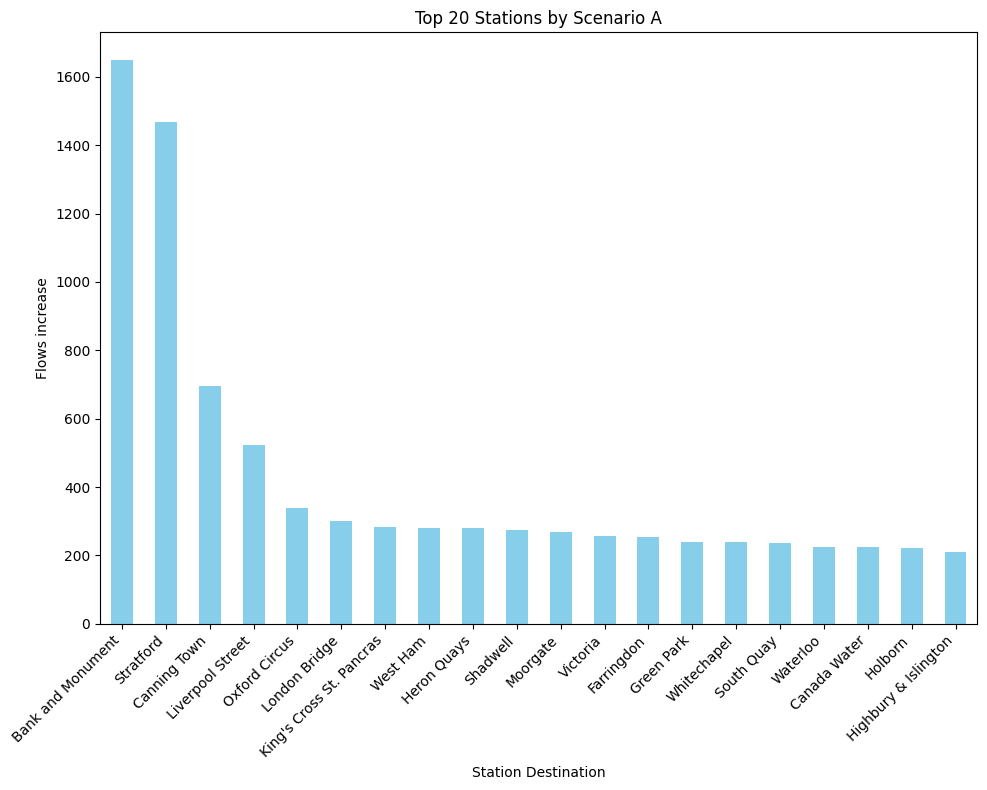

In [360]:
# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
top_15_changeA1_byAll['Flows_A'].plot(kind='bar', color='skyblue')

plt.title('Top 20 Stations by Scenario A')  # Chart title
plt.xlabel('Station Destination')  # X-axis label
plt.ylabel('Flows increase')  # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()


In [354]:
changeA1_byAll = change_A.loc['All']
changeA1_byAll = changeA1_byAll.to_frame(name='Flows')
changeA1_byAllNeg = changeA1_byAll.sort_values(by='Flows', ascending=True)
top_15_changeA1_byAllNeg = changeA1_byAllNeg.head(20)
top_15_changeA1_byAllNeg

,Flows
station_destination,
Canary Wharf,-18192.0
Harold Wood,0.0
Headstone Lane,0.0
Crystal Palace,0.0
Heathrow Terminal 4,0.0
Chalfont & Latimer,0.0
Crouch Hill,0.0
Heathrow Terminal 5,0.0
West Ruislip,0.0


In [355]:
change_A

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,6.0
Aldgate,NaN,NaN,0.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,...,0.0,NaN,1.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0
Aldgate East,NaN,NaN,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-7.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [305]:
bakerloo_all_data = change_B1.loc['All', bakerloo]
bakerloo_all_data = bakerloo_all_data.to_frame(name='Flows_B1')
bakerloo_all_data['Flows_A'] = change_A.loc['All', bakerloo]




,Flows_B1
station_destination,
Baker Street,-418.0
Charing Cross,-1.0
Edgware Road,-373.0
Elephant & Castle,-173.0
Embankment,83.0
Harlesden,-187.0
Harrow & Wealdstone,63.0
Kensal Green,-83.0
Kenton,65.0


In [311]:
central_all_data = change_B1.loc['All', central]
central_all_data = central_all_data.to_frame(name='Flows_B1')
central_all_data['Flows_A'] = change_A.loc['All', central]

In [316]:
circle_all_data = change_B1.loc['All', circle]
circle_all_data = circle_all_data.to_frame(name='Flows_B1')
circle_all_data['Flows_A'] = change_A.loc['All', circle]

In [319]:
district_all_data = change_B1.loc['All', district]
district_all_data = district_all_data.to_frame(name='Flows_B1')
district_all_data['Flows_A'] = change_A.loc['All', district]

In [320]:
hammersmithcity_all_data = change_B1.loc['All', hammersmithcity]
hammersmithcity_all_data = hammersmithcity_all_data.to_frame(name='Flows_B1')
hammersmithcity_all_data['Flows_A'] = change_A.loc['All', hammersmithcity]

In [321]:
metropolitan_all_data = change_B1.loc['All', metropolitan]
metropolitan_all_data = metropolitan_all_data.to_frame(name='Flows_B1')
metropolitan_all_data['Flows_A'] = change_A.loc['All', metropolitan]

In [324]:
northern_all_data = change_B1.loc['All', northern]
northern_all_data = northern_all_data.to_frame(name='Flows_B1')
northern_all_data['Flows_A'] = change_A.loc['All', northern]

In [327]:
overground_all_data = change_B1.loc['All', overground]
overground_all_data = overground_all_data.to_frame(name='Flows_B1')
overground_all_data['Flows_A'] = change_A.loc['All', overground]

In [330]:
piccadilly_all_data = change_B1.loc['All', piccadilly]
piccadilly_all_data = piccadilly_all_data.to_frame(name='Flows_B1')
piccadilly_all_data['Flows_A'] = change_A.loc['All', piccadilly]

In [331]:
victoria_all_data = change_B1.loc['All', victoria]
victoria_all_data = victoria_all_data.to_frame(name='Flows_B1')
victoria_all_data['Flows_A'] = change_A.loc['All', victoria]

In [335]:
jubilee_all_data = change_B1.loc['All', jubilee]
jubilee_all_data = jubilee_all_data.to_frame(name='Flows_B1')
jubilee_all_data['Flows_A'] = change_A.loc['All', jubilee]
jubilee_all_data

,Flows_B1,Flows_A
station_destination,,
Baker Street,-418.0,138.0
Bermondsey,-320.0,51.0
Bond Street,-322.0,173.0
Canada Water,-1038.0,224.0
Canary Wharf,-1221.0,-18192.0
Canning Town,447.0,696.0
Canons Park,193.0,0.0
Dollis Hill,62.0,5.0
Finchley Road,-312.0,25.0


In [336]:
# Dictionary of DataFrames for each tube line
tube_lines = {
    'Jubilee': jubilee_all_data,
    'Bakerloo': bakerloo_all_data,
    'Central': central_all_data,
    'Circle': circle_all_data,
    'District': district_all_data,
    'Victoria': victoria_all_data,
    'Piccadilly': piccadilly_all_data,
    'Hammersmithcity': hammersmithcity_all_data,
    'Metropolitan': metropolitan_all_data,
    'Overground': overground_all_data,
    'Northern': northern_all_data
}


In [337]:
# Create an empty DataFrame for storing summary totals
summarytube_df = pd.DataFrame(columns=['Tube Line', 'TotalB1', 'TotalA'])


In [339]:
# Loop through each tube line and calculate totals
for line_name, data in tube_lines.items():
    total_b1 = data['Flows_B1'].sum()  # Sum of Flows_B1 for the tube line
    total_a = data['Flows_A'].sum()    # Sum of Flows_A for the tube line
    
    # Append the totals to the summary DataFrame
    summarytube_df = summarytube_df.append({
        'Tube Line': line_name,
        'TotalB1': total_b1,
        'TotalA': total_a
    }, ignore_index=True)


C:\Users\Andrio Emilio\AppData\Local\Temp\ipykernel_32228\296021619.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summarytube_df = summarytube_df.append({
C:\Users\Andrio Emilio\AppData\Local\Temp\ipykernel_32228\296021619.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summarytube_df = summarytube_df.append({
C:\Users\Andrio Emilio\AppData\Local\Temp\ipykernel_32228\296021619.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summarytube_df = summarytube_df.append({
C:\Users\Andrio Emilio\AppData\Local\Temp\ipykernel_32228\296021619.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summarytube_df = summarytube_df.append({


In [341]:
# Display the complete summary DataFrame
print(summarytube_df)


          Tube Line  TotalB1   TotalA
0           Jubilee  -5516.0 -13832.0
1          Bakerloo  -4520.0   1528.0
2           Central  -7252.0   5549.0
3            Circle -15463.0   5335.0
4          District  -7570.0   4848.0
5          Victoria  -2656.0   2112.0
6        Piccadilly   3424.0   1814.0
7   Hammersmithcity  -9108.0   3042.0
8      Metropolitan   3464.0   1901.0
9        Overground  -6821.0   3852.0
10         Northern  -5089.0   4520.0


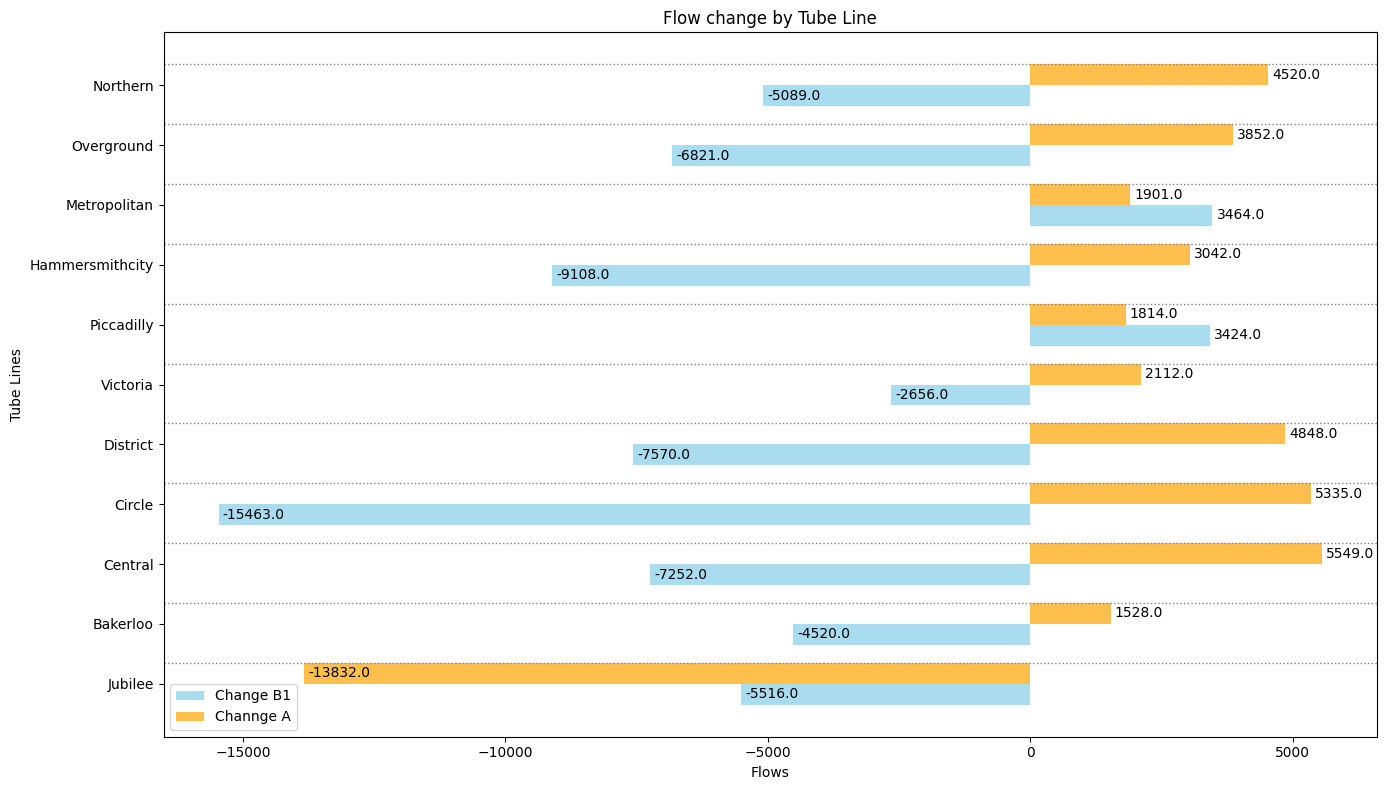

In [370]:
import matplotlib.pyplot as plt
import numpy as np

# Data setup
tube_lines = summarytube_df['Tube Line']
total_b1 = summarytube_df['TotalB1']
total_a = summarytube_df['TotalA']

y = np.arange(len(tube_lines))  # the label locations for y-axis
height = 0.35  # the height of the bars

fig, ax = plt.subplots(figsize=(14, 8))
# Horizontal bars
rects1 = ax.barh(y - height/2, total_b1, height, label='Change B1', color='skyblue', alpha=0.7)
rects2 = ax.barh(y + height/2, total_a, height, label='Channge A', color='orange', alpha=0.7)

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Tube Lines')
ax.set_xlabel('Flows')
ax.set_title('Flow change by Tube Line')
ax.set_yticks(y)
ax.set_yticklabels(tube_lines)
ax.legend()

# Adding horizontal dotted lines for separation between each tube line
for ypos in y:
    ax.axhline(y=ypos + height, color='grey', linestyle=':', linewidth=1)  # adjust linewidth and style as needed

# Function to attach a label next to each bar, showing its width
def autolabel(rects):
    """Attach a text label next to each bar in *rects*, displaying its width."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

# Call the function to label the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Show the plot
plt.show()
